In [1]:
# this is used to analyse the rotation of the halo with K-giants
%matplotlib inline
import numpy as np
import csv
import CoordinateConversion as CC
import matplotlib.pyplot as plt
# import pandas as pd
import math
import PyAstronomy as PA
from PyAstronomy import pyasl as PAP
from scipy import signal
import scipy.optimize as SO

In [2]:
path = "/Users/naoc/Documents/tian/rothalo/"
dpath = path + "data/"
ppath = path + "plot/"

fn_halo = "LMDR3_haloRGB2.dat"
fn_disk = "LMDR3_diskRGB2.dat"

In [3]:
# read the data--------------------------
data_halo = np.loadtxt(dpath+fn_halo,skiprows=1)
# obsid ra dec l b teff logg feh rv Mgb MK MKerr_low MKerr_up AK K dist disterr_low disterr_up Z R r_gc lnnu
ind = data_halo[:,21]>-10000000
ra = data_halo[ind,1]
dec = data_halo[ind,2]
l = data_halo[ind,3]
b = data_halo[ind,4]
feh = data_halo[ind,7]
rv = data_halo[ind,8]
dist = data_halo[ind,15]
Z = data_halo[ind,18]
R = data_halo[ind,19]
r_gc = data_halo[ind,20]
lnnu = data_halo[ind,21]
DD = np.sqrt(R**2+Z**2)
Vgsr = rv+9.58*np.cos(b*math.pi/180)*np.cos(l*math.pi/180)+ \
(220+10.52)*np.cos(b*math.pi/180)*np.sin(l*math.pi/180)+ \
7.01*np.sin(b*math.pi/180)
print(np.max(lnnu),np.min(lnnu),len(lnnu[lnnu>-1000]),len(ra))

-6.3 -528.3 5166 5166


In [4]:
# calculate the spherical coordinates centered at the galactic center
# aitoff projection
X_sun = 8.0
Xs,Ys,Zs = CC.sph2xyz(90-b,l,r=dist,Degree=True)
rcc,thetacc,phicc = CC.xyz2sph(X_sun-Xs,Ys,Zs,Degree=True)
Lgc = phicc
Bgc = 90-thetacc
# plt.plot(Lgc,Bgc,'k.')

In [5]:
# this is used to smooth the distribution
Ar = 2.5
cosAr = np.cos(Ar*math.pi/180)
ns = len(l)
M_vg = np.zeros(ns)
M_nu = np.zeros(ns)
Disp_nu = np.zeros(ns)
Disp_vg = np.zeros(ns)
M_rv = np.zeros(ns)
for i in range(0,ns):
    cosx = ((X_sun-Xs)*(X_sun-Xs[i])+Ys*Ys[i]+ \
            Zs*Zs[i])/np.sqrt((X_sun-Xs[i])**2+Ys[i]**2+Zs[i]**2)/\
    np.sqrt((X_sun-Xs)**2+Ys[i]**2+Zs[i]**2)
    indc = cosx>cosAr
    if len(Vgsr[indc])>0:
        M_vg[i] = np.mean(Vgsr[indc])
        M_nu[i] = np.log(np.mean(math.e**(lnnu[indc])))
        Disp_vg[i] = np.std(Vgsr[indc])
        Disp_nu[i] = np.std(math.e**(lnnu[indc]))
        
    cosxs = ((Xs)*(X_sun-Xs[i])+Ys*Ys[i]+ \
            Zs*Zs[i])/np.sqrt((Xs[i])**2+Ys[i]**2+Zs[i]**2)/\
    np.sqrt((Xs)**2+Ys[i]**2+Zs[i]**2)
    indcs = cosxs>cosAr
    M_rv[i] = np.mean(rv[indcs])

/Users/naoc/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/naoc/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
# THIS IS USED TO DO AITOFF CONVERSION
Xa, Ya = PAP.aitoff(Lgc, Bgc)
Xas,Yas = PAP.aitoff(l,b)

In [7]:
# convert lb to aitoff projection
nl = 2000
nb = 1000
Xa,Ya = PAP.aitoff(Lgc,Bgc)
bba = np.linspace(-90,90,nb+1)
lla = np.linspace(-180,180,nl+1)
bla = np.zeros(nl)
lba = np.zeros(nb)
b0,b30,b60,b130,b160 = 0,30,60,-30,-60
l0,l60,l120,l180,l060,l0120,l0180 = 0,60,120,180,-60,-120,-180
Xab0,Yab0 = PAP.aitoff(lla[:nl],bla+b0)
Xab30,Yab30 = PAP.aitoff(lla[:nl],bla+b30)
Xab60,Yab60 = PAP.aitoff(lla[:nl],bla+b60)
Xab130,Yab130 = PAP.aitoff(lla[:nl],bla+b130)
Xab160,Yab160 = PAP.aitoff(lla[:nl],bla+b160)


Xal0,Yal0 = PAP.aitoff(lba+l0,bba[:nb])
Xal60,Yal60 = PAP.aitoff(lba+l60,bba[:nb])
Xal120,Yal120 = PAP.aitoff(lba+l120,bba[:nb])
Xal180,Yal180 = PAP.aitoff(lba+l180,bba[:nb])
Xal060,Yal060 = PAP.aitoff(lba+l060,bba[:nb])
Xal0120,Yal0120 = PAP.aitoff(lba+l0120,bba[:nb])
Xal0180,Yal0180 = PAP.aitoff(lba+l0180,bba[:nb])


# plot density and Vgsr

In [8]:
def Gaussian2(x,a1,a2,m1,m2,s1,s2):
    return a1*np.exp(-((x-m1)/s1)**2)+a2*np.exp(-((x-m2)/s2)**2)
def Gaussian1(x,a,m,s):
    return a*np.exp(-((x-m)/s)**2)

/Users/naoc/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/naoc/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


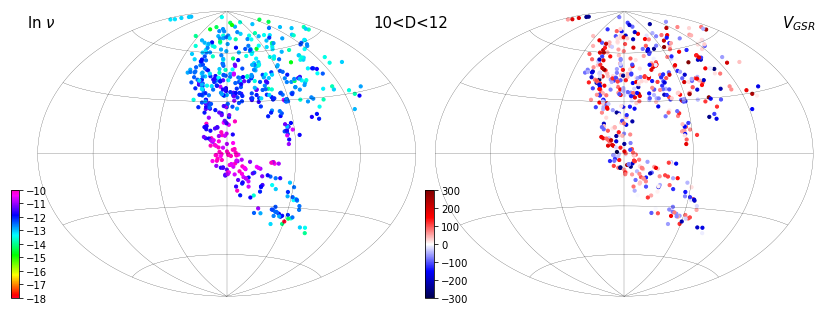

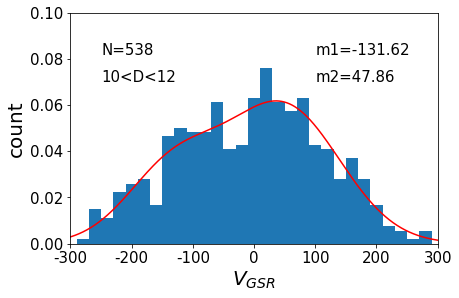

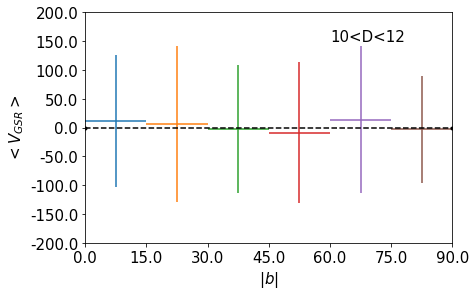

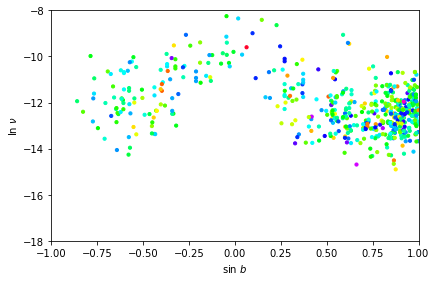

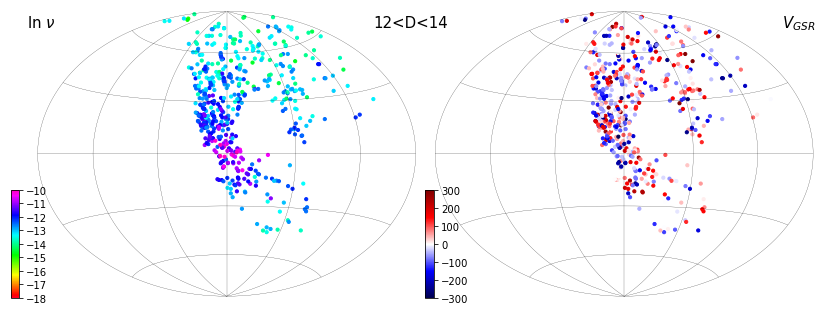

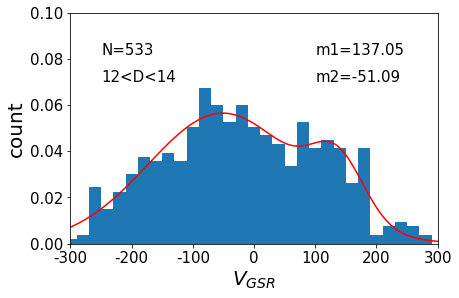

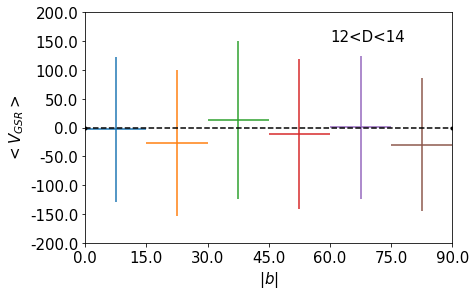

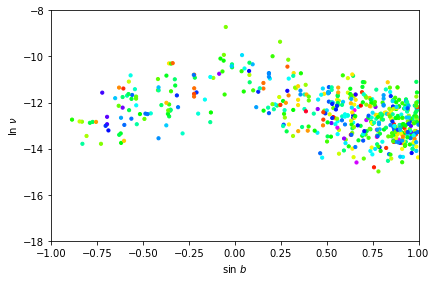

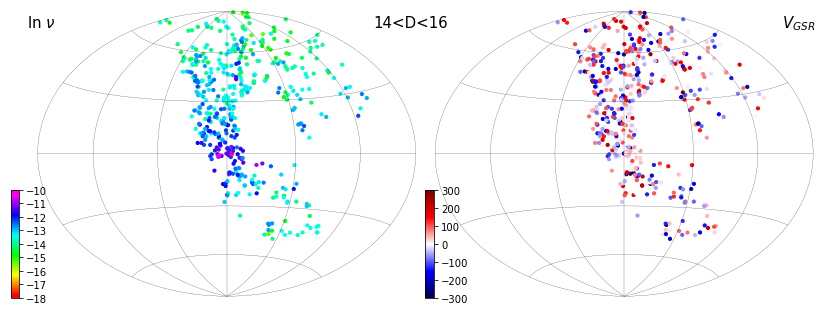

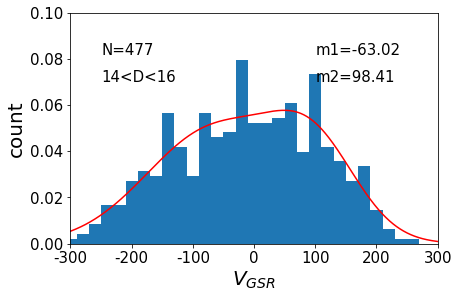

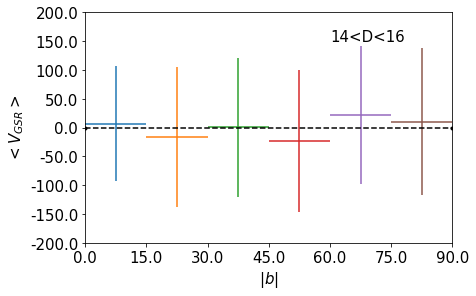

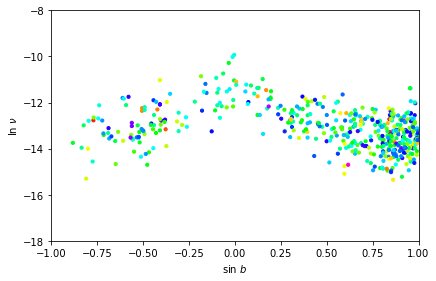

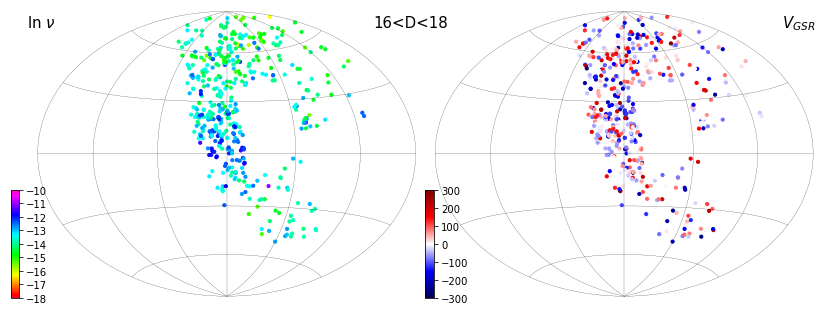

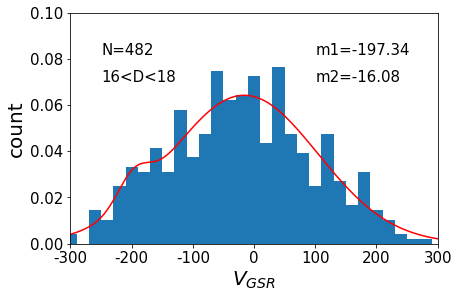

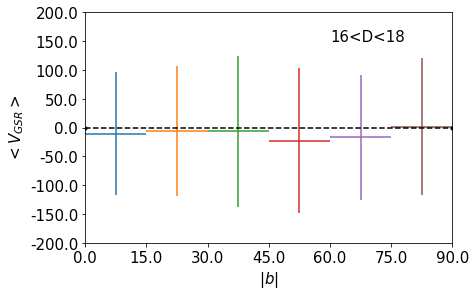

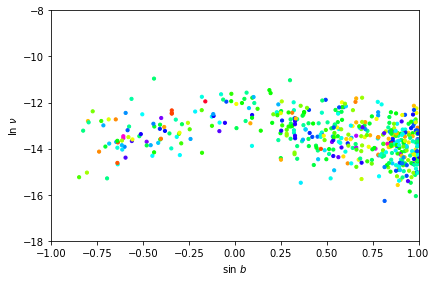

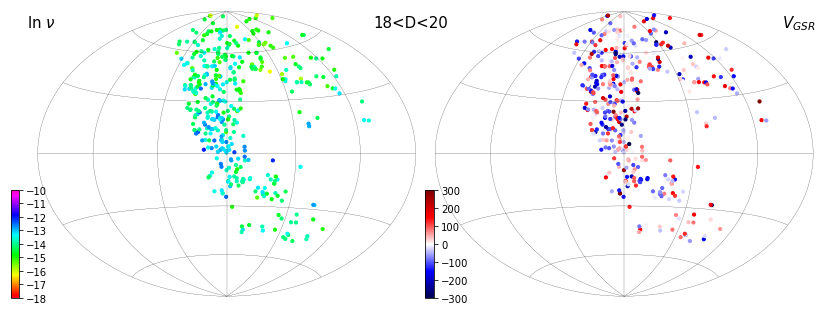

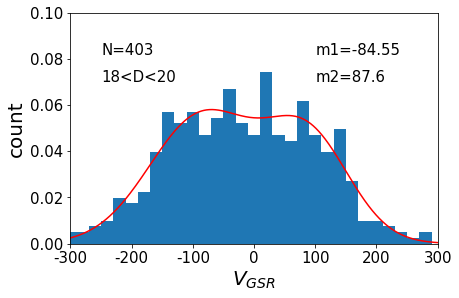

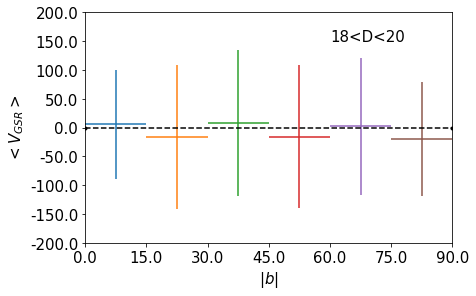

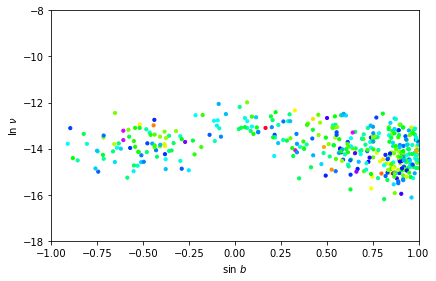

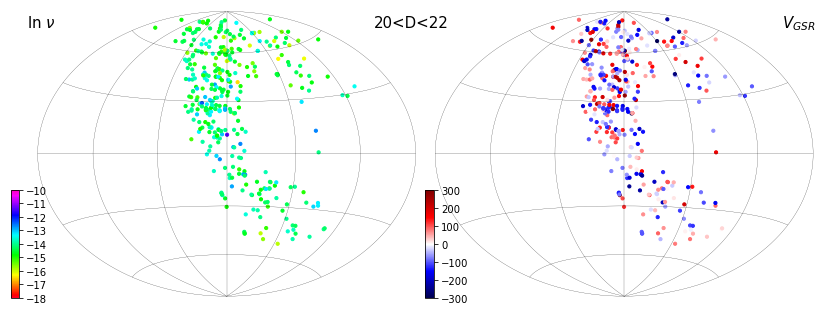

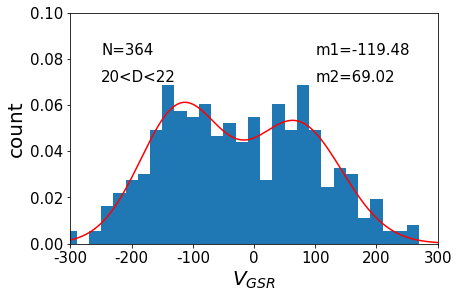

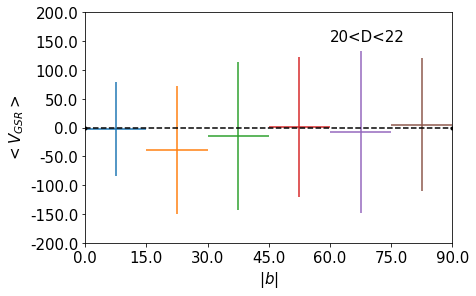

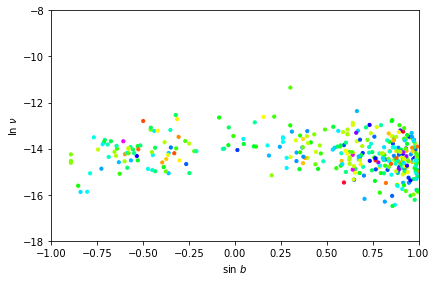

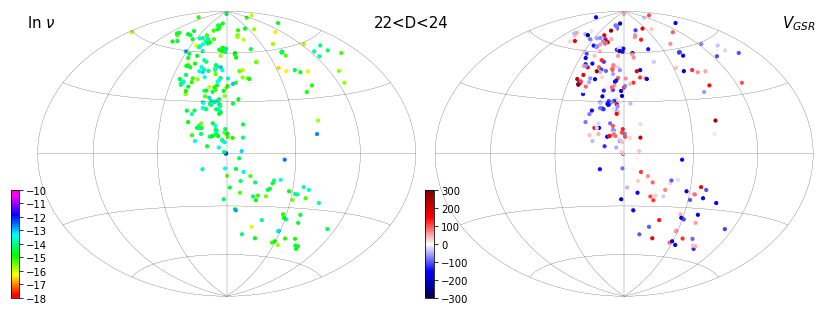

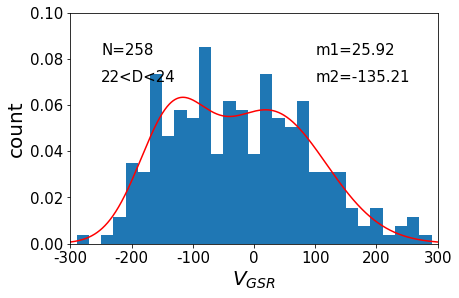

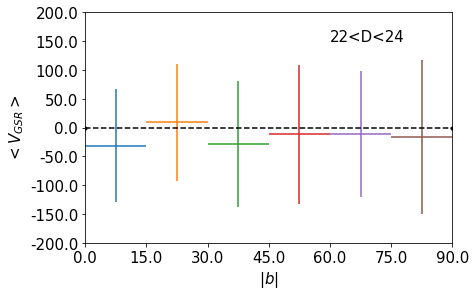

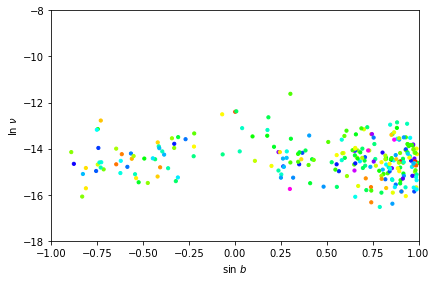

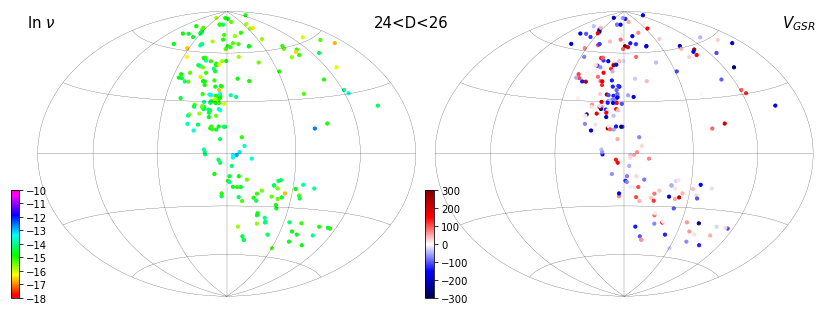

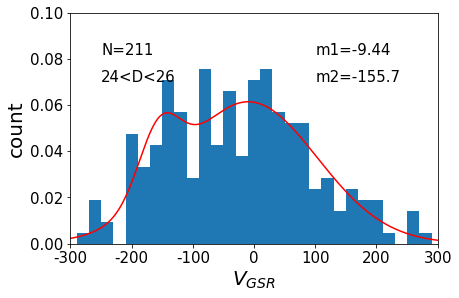

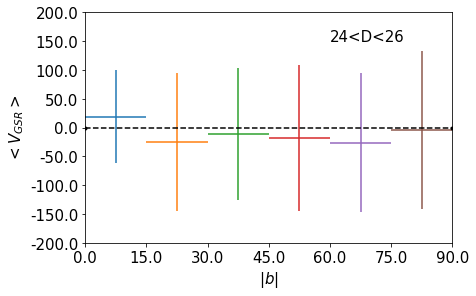

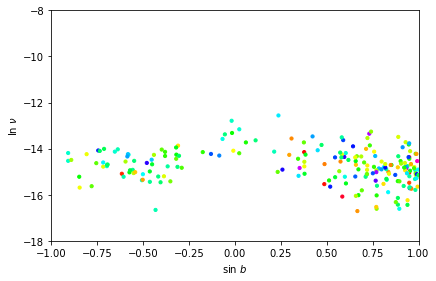

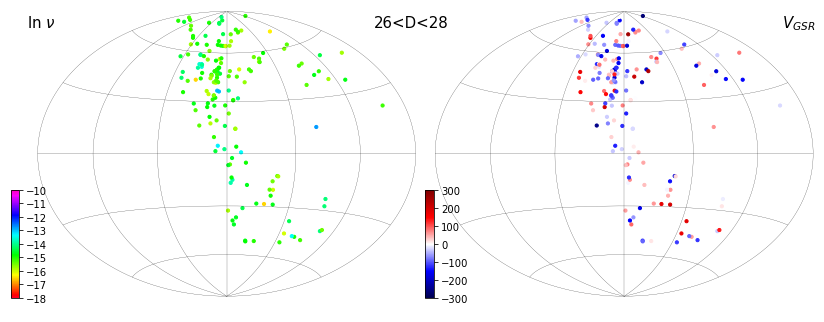

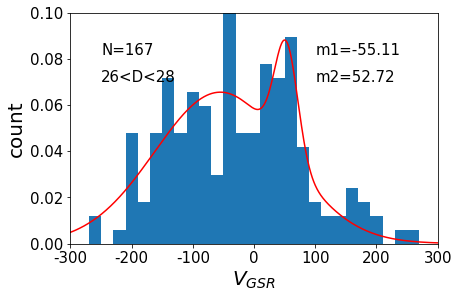

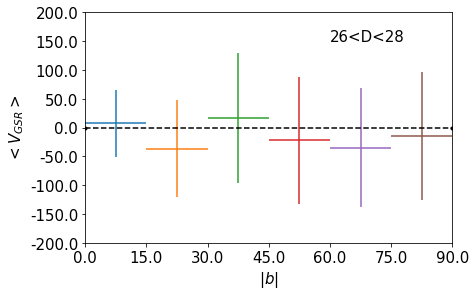

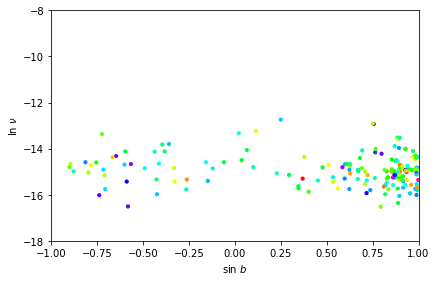

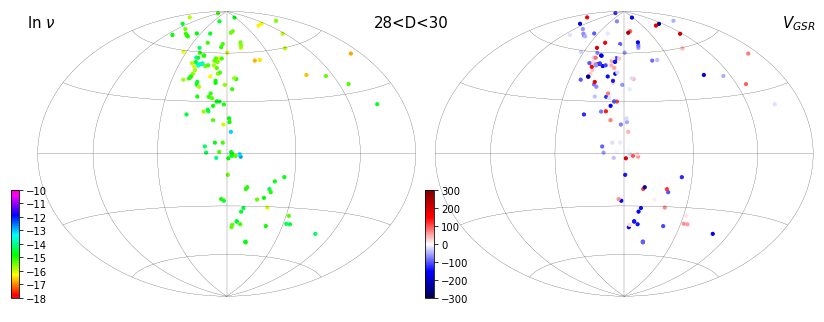

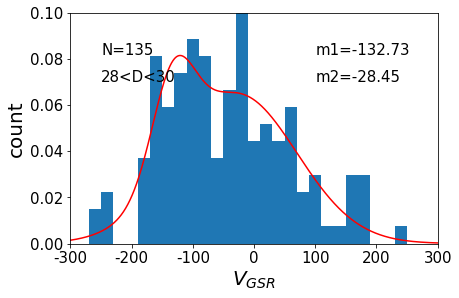

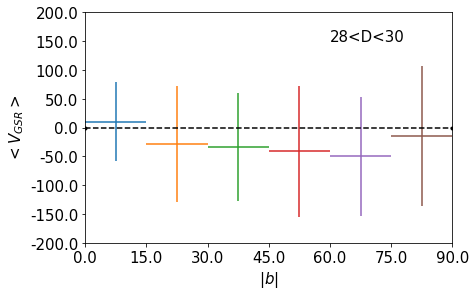

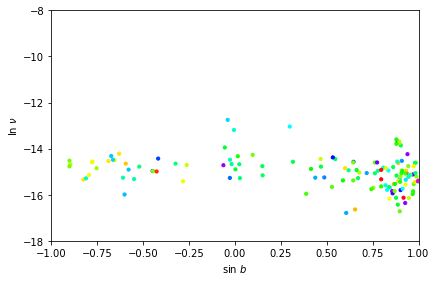

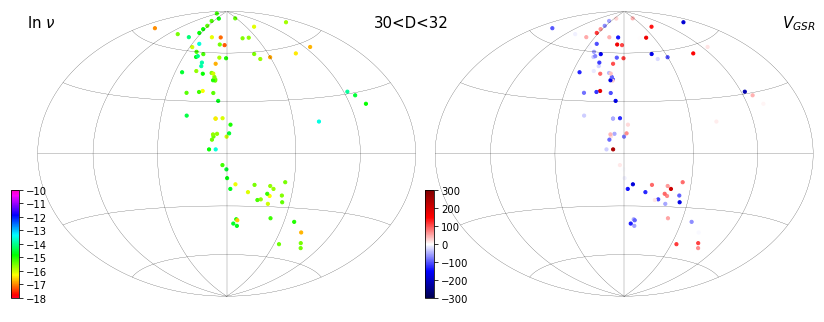

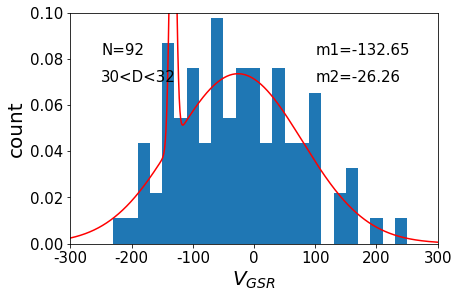

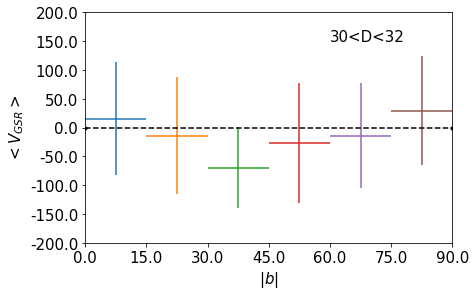

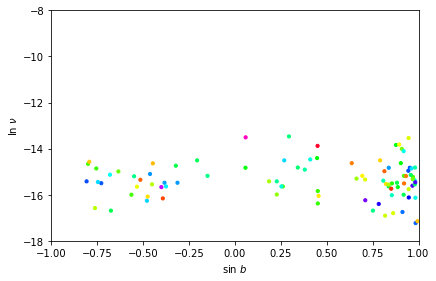

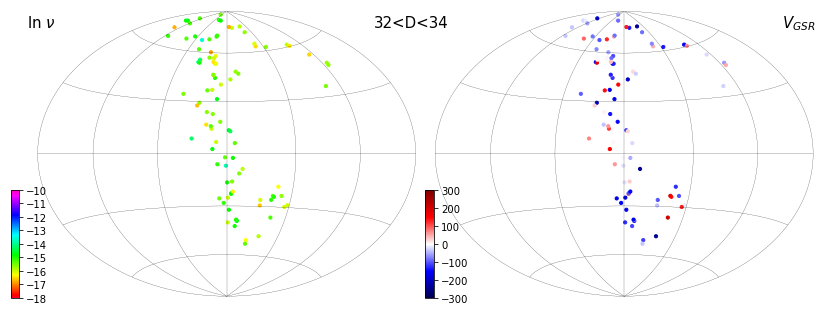

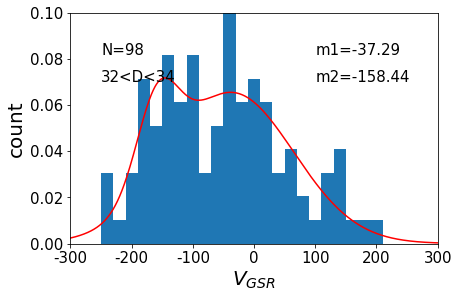

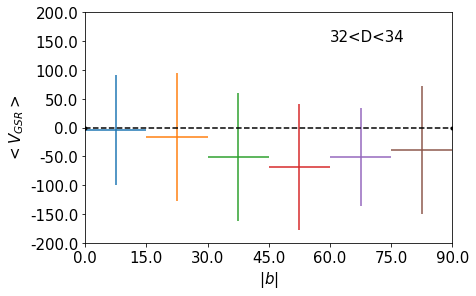

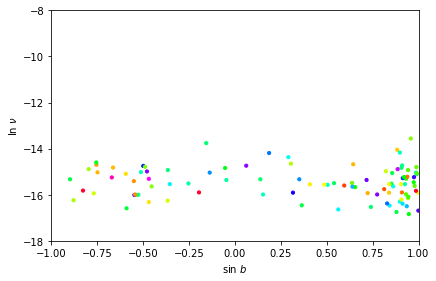

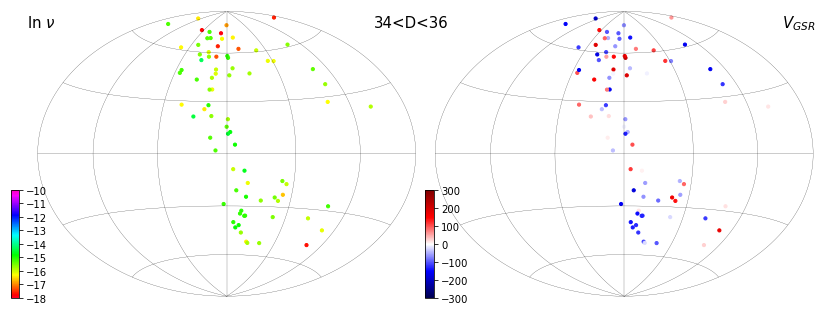

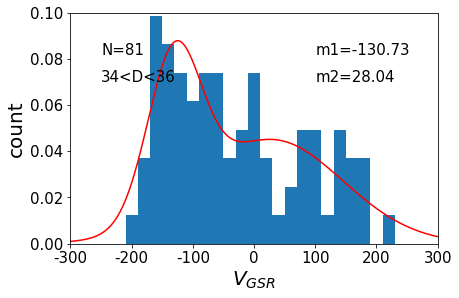

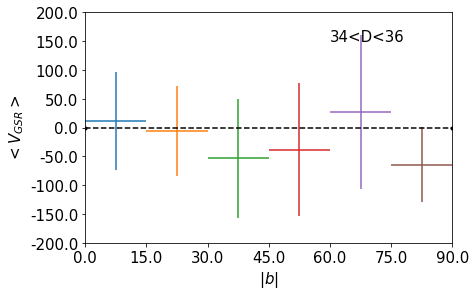

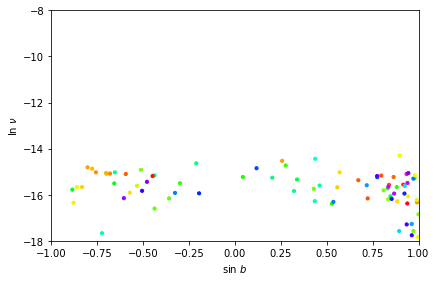

In [18]:
lw=0.2
# bbins = np.array([-50,-40,-30,-20,-10,0,10,20,30,40,50,60,75,90]) #13 bins
# sym = ['b--','c--','r--','y--','m--','m-','y-','r-','c-','b-','k-','k--','k-.']
# bbins = np.linspace(-50,90,8)
# sym = ['b--','c--','k-','r-','c-','g-','m-']
bbins = np.linspace(0,90,7)
sym = ['m-','y-','r-','c-','b-','k-','r-','g-']
lsym = ['m--','y--','r--','c--','b--','k--','r--','g--']
for i in range(0,13):   #13
    dmin = 10+2*i
    dmax = dmin+2
    indd = (DD>dmin) & (DD<dmax)
    nsd = len(DD[indd])
#     print(len(DD[indd]))
#     plt.close("all")
    fig1 = plt.figure(figsize=(12,5))
    ax1 = fig1.add_axes([0.05,0.1,0.44,0.8])
    ax2 = fig1.add_axes([0.51,0.1,0.44,0.8])
    ax1.plot(Xab0,Yab0,'k-',linewidth=lw)
    ax1.plot(Xab30,Yab30,'k-',linewidth=lw)
    ax1.plot(Xab60,Yab60,'k-',linewidth=lw)
    ax1.plot(Xab130,Yab130,'k-',linewidth=lw)
    ax1.plot(Xab160,Yab160,'k-',linewidth=lw)
    ax1.plot(Xal0,Yal0,'k-',linewidth=lw)
    ax1.plot(Xal60,Yal60,'k-',linewidth=lw)
    ax1.plot(Xal120,Yal120,'k-',linewidth=lw)
    ax1.plot(Xal180,Yal180,'k-',linewidth=lw)
    ax1.plot(Xal060,Yal060,'k-',linewidth=lw)
    ax1.plot(Xal0120,Yal0120,'k-',linewidth=lw)
    ax1.plot(Xal0180,Yal0180,'k-',linewidth=lw)
    cax1 = ax1.scatter(Xa[indd],Ya[indd],s=10,c=lnnu[indd],vmin=-18,vmax=-10,cmap='gist_rainbow')
    ax1.axis([-181,181,-91,91])
    ax1.axis("off")

    ax2.plot(Xab0,Yab0,'k-',linewidth=lw)
    ax2.plot(Xab30,Yab30,'k-',linewidth=lw)
    ax2.plot(Xab60,Yab60,'k-',linewidth=lw)
    ax2.plot(Xab130,Yab130,'k-',linewidth=lw)
    ax2.plot(Xab160,Yab160,'k-',linewidth=lw)
    ax2.plot(Xal0,Yal0,'k-',linewidth=lw)
    ax2.plot(Xal60,Yal60,'k-',linewidth=lw)
    ax2.plot(Xal120,Yal120,'k-',linewidth=lw)
    ax2.plot(Xal180,Yal180,'k-',linewidth=lw)
    ax2.plot(Xal060,Yal060,'k-',linewidth=lw)
    ax2.plot(Xal0120,Yal0120,'k-',linewidth=lw)
    ax2.plot(Xal0180,Yal0180,'k-',linewidth=lw)
    cax2 = ax2.scatter(Xa[indd],Ya[indd],s=10,c=Vgsr[indd],vmin=-300,vmax=300,cmap="seismic")
    ax2.axis([-181,181,-91,91])
    ax2.axis("off")
    
    ax1.text(140,80,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    ax1.text(-190,80,"ln $\\nu$".format(**locals()),fontsize=15)
    ax2.text(150,80,"$V_{GSR}$",fontsize=15)
    
    ax3 = fig1.add_axes([0.02,0.1,0.01,0.3])
    ax4 = fig1.add_axes([0.5,0.1,0.01,0.3])
    plt.colorbar(cax1,ax3)
    plt.colorbar(cax2,ax4)
    plt.savefig(ppath+"lnnu_Vgsr_vx_D_{dmin}_{dmax}.eps".format(**locals()))
#     plt.close(fig1)
    
    figh = plt.figure(figsize=(6,4))
    ax = figh.add_axes([0.12,0.17,0.85,0.8])
    hy,hx = np.histogram(Vgsr[indd],bins=np.linspace(-300,300,31))
    popt,pcov = SO.curve_fit(Gaussian2,hx[:len(hx)-1],hy*1.0/nsd,bounds=([0,0,-300,-300,0,0],\
        [1,1,300,300,300,300]))
    m1 = round(popt[2],2)
    m2 = round(popt[3],2)
    xxxx = np.linspace(-300,300,1000)  
    plt.bar(hx[:len(hx)-1],hy*1.0/nsd,width=20)
    plt.plot(xxxx,Gaussian2(xxxx,*popt),'r-')
    plt.xlabel("$V_{GSR}$",fontsize=20)
    plt.ylabel("count",fontsize=20)
    plt.axis([-300,300,0,0.1])
    plt.yticks(np.linspace(0,0.1,6),['0.00','0.02','0.04','0.06','0.08','0.10'],fontsize=15)
    plt.xticks(np.linspace(-300,300,7),['-300','-200','-100','0','100','200','300'],fontsize=15)
    plt.text(-250,0.07,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    plt.text(-250,0.082,"N={nsd}".format(**locals()),fontsize=15)
    plt.text(100,0.082,"m1={m1}".format(**locals()),fontsize=15)
    plt.text(100,0.07,"m2={m2}".format(**locals()),fontsize=15)
    plt.savefig(ppath+"hist_Vgsr_D_{dmin}_{dmax}.eps".format(**locals()))
#     check the mean velocity along the latitude
    figb = plt.figure(figsize=(6,4))
    figbb = plt.figure(figsize=(6,4))
    ax2 = figbb.add_axes([0.12,0.17,0.85,0.8])
    ax1 = figb.add_axes([0.12,0.17,0.85,0.8])
    for k in range(0,len(bbins)-1):
        inddb = (DD>dmin) & (DD<dmax) & (np.abs(b)>=bbins[k]) & (np.abs(b)<bbins[k+1])
        if len(DD[inddb])>0:
            hyb,hxb = np.histogram(Vgsr[inddb],bins=np.linspace(-300,300,16))
            bmin = int(bbins[k])
            bmax = int(bbins[k+1])
            ax1.plot(hxb[:len(hxb)-1],hyb*1.0/len(DD[indd]),sym[k],\
                     label='{bmin}$^\\circ$<|b|<{bmax}$^\\circ$'.format(**locals()),linewidth=3)
            ax1.plot([np.mean(Vgsr[inddb]),np.mean(Vgsr[inddb])],[0,1],lsym[k],linewidth=2)
            ax2.errorbar([bbins[k]+7.5],[np.mean(Vgsr[inddb])],xerr = 7.5,yerr=np.std(Vgsr[inddb]))
    ax1.set_xlim((-300,350))
    ax1.set_ylim((0,0.06))
    ax1.set_xticks(np.linspace(-300,300,7))
    ax1.set_xticklabels(['-300','-200','-100','0','100','200','300'],fontsize=15)
    ax1.set_xlabel('$V_{GSR}$',fontsize=15)
    ax1.set_yticks(np.linspace(0,0.06,4))
    ax1.set_yticklabels(np.linspace(0,0.06,4),fontsize=15)
    ax1.set_ylabel('$f$',fontsize=15)
    ax1.legend(loc=1,fontsize=10)
    ax1.text(-280,0.05,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    figb.savefig(ppath+"Vgsr_D_B_{dmin}_{dmax}.eps".format(**locals()))
    
    
    ax2.plot([0,90],[0,0],'k.--',linewidth=1.5)
    ax2.set_xlim((0,90))
    ax2.set_ylim((-200,200))
    ax2.set_xticks(np.linspace(0,90,7))
    ax2.set_xticklabels(np.linspace(0,90,7),fontsize=15)
    ax2.set_xlabel('|$b$|',fontsize=15)
    ax2.set_yticks(np.linspace(-200,200,9))
    ax2.set_yticklabels(np.linspace(-200,200,9),fontsize=15)
    ax2.set_ylabel('$<V_{GSR}>$',fontsize=15)
    ax2.legend(loc=1,fontsize=10)
    ax2.text(60,150,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    figbb.savefig(ppath+"Vgsr_B_{dmin}_{dmax}.eps".format(**locals()))
    plt.close(figb)

    figdv = plt.figure(figsize=(6,4))
    ax0 = figdv.add_axes([0.12,0.17,0.85,0.8])
    ax0.scatter(np.sin(b[indd]*math.pi/180),lnnu[indd],c=Vgsr[indd],s=10,cmap='gist_rainbow')
    ax0.set_ylim((-18,-8))
    ax0.set_xlim((-1,1))
    ax0.set_xlabel('sin $b$')
    ax0.set_ylabel('ln $\\nu$')
#     ax1.set_xlim((-300,300))

# plot average density and Vgsr

/Users/naoc/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/naoc/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


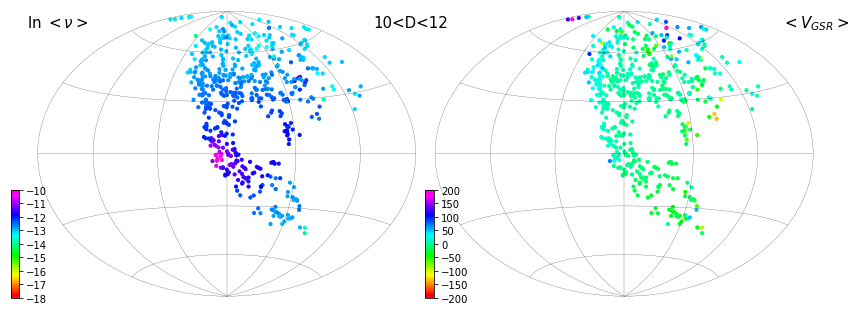

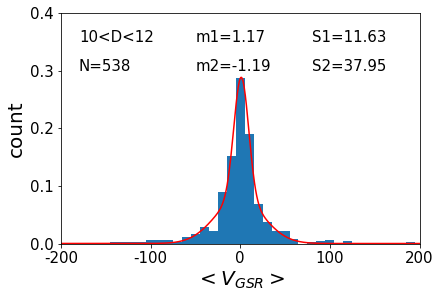

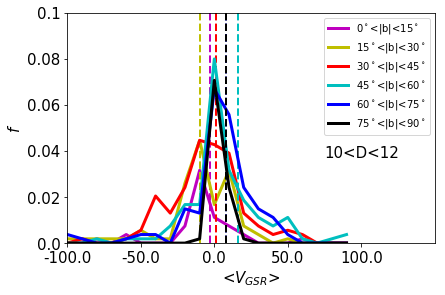

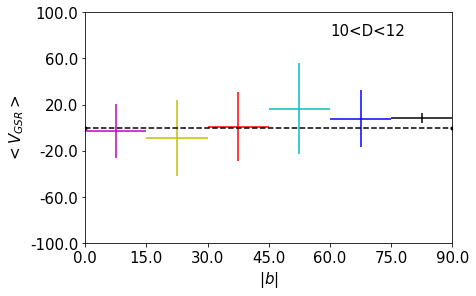

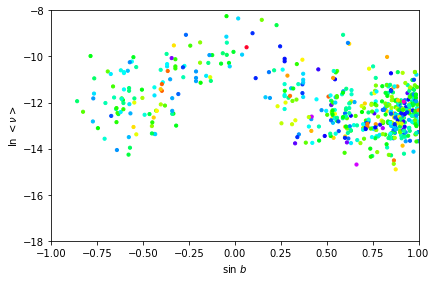

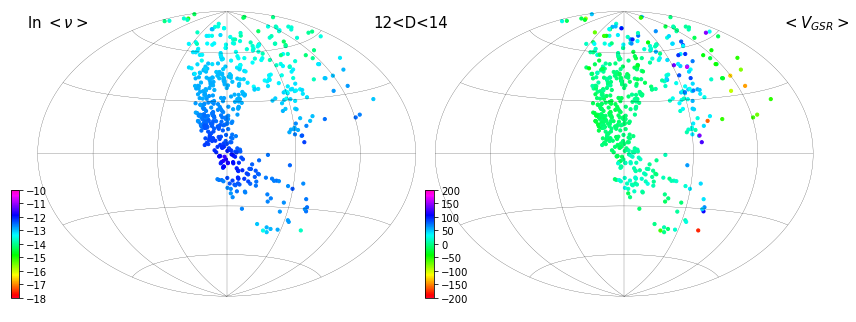

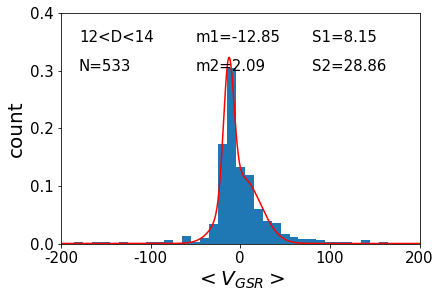

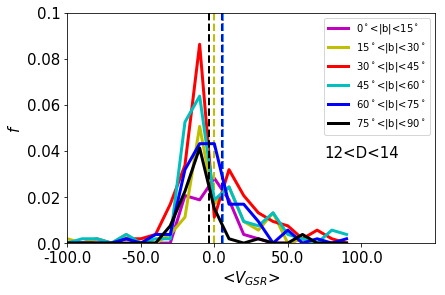

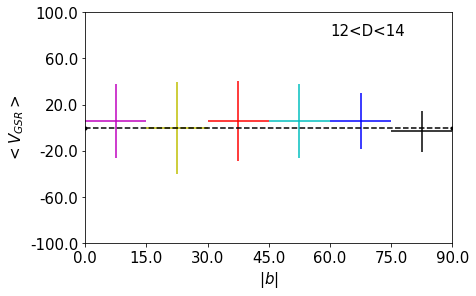

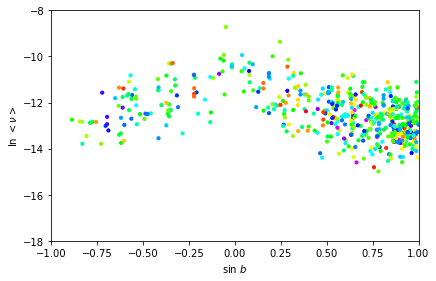

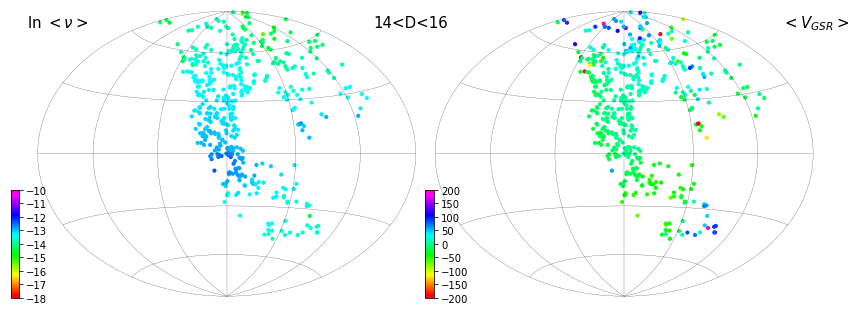

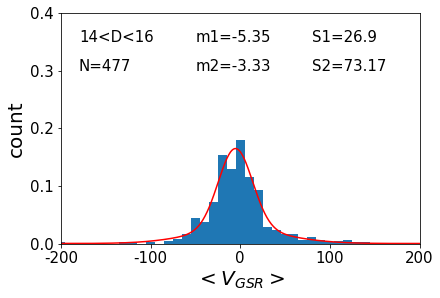

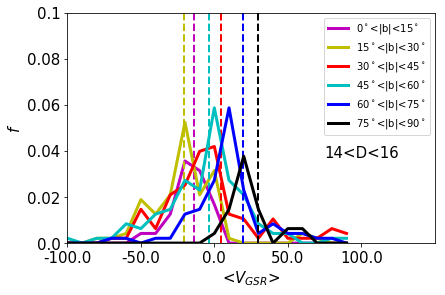

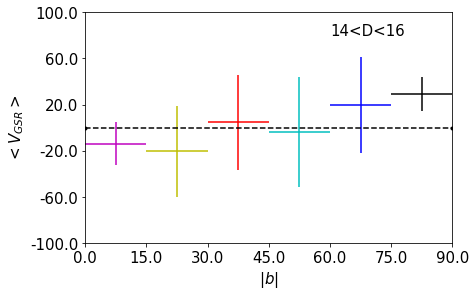

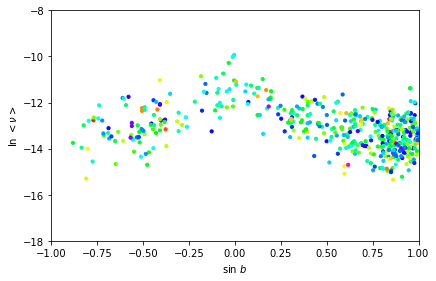

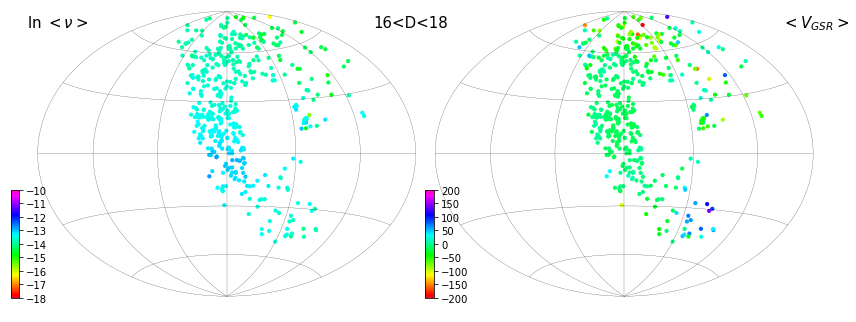

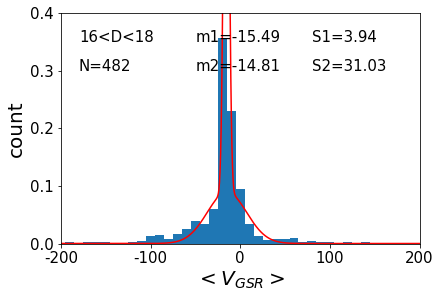

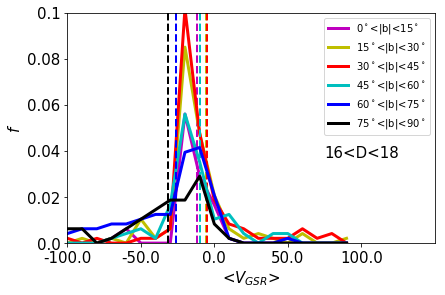

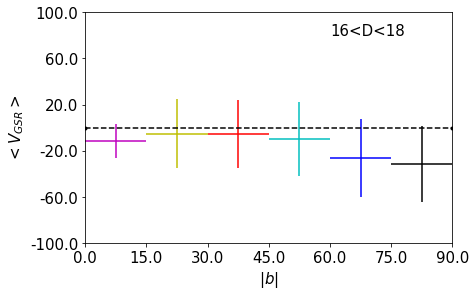

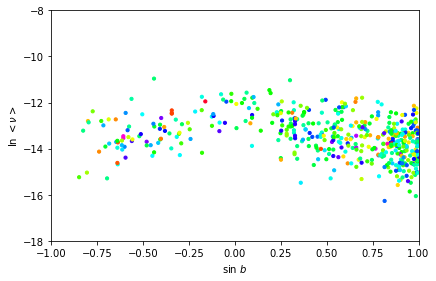

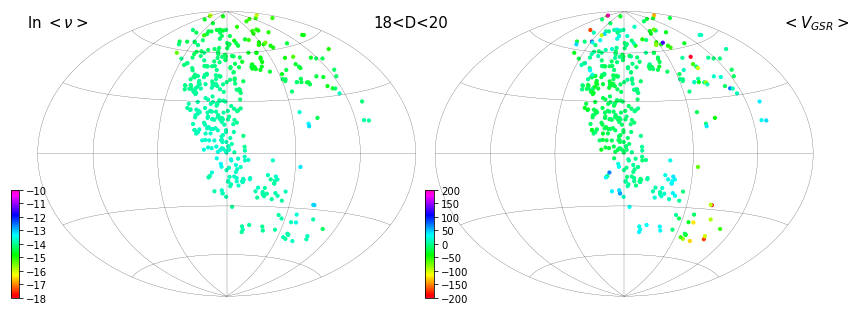

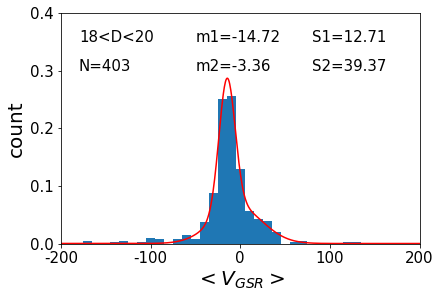

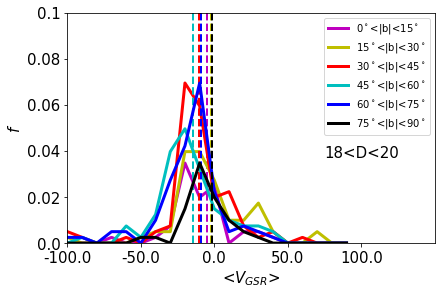

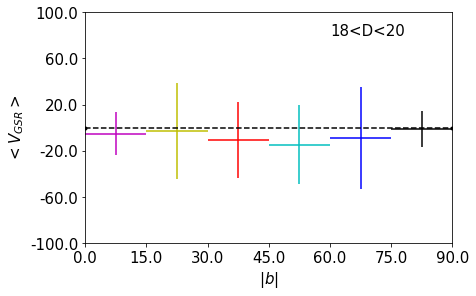

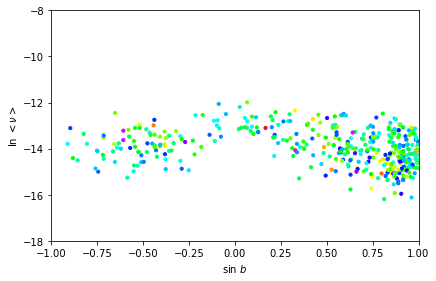

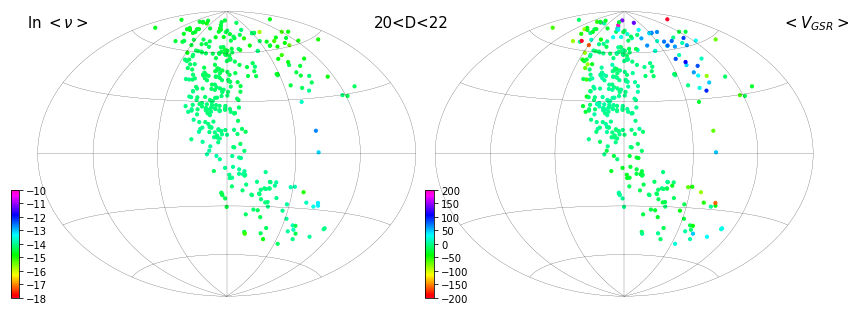

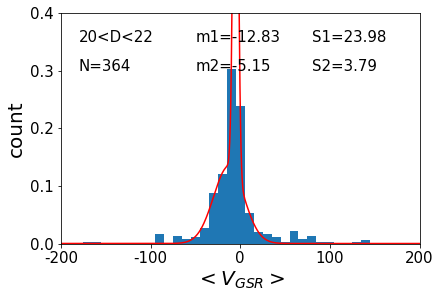

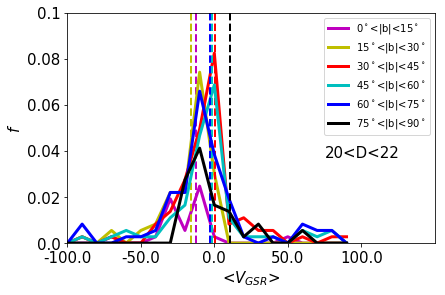

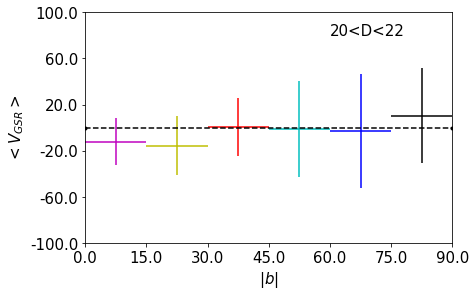

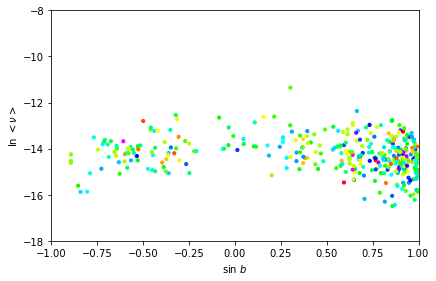

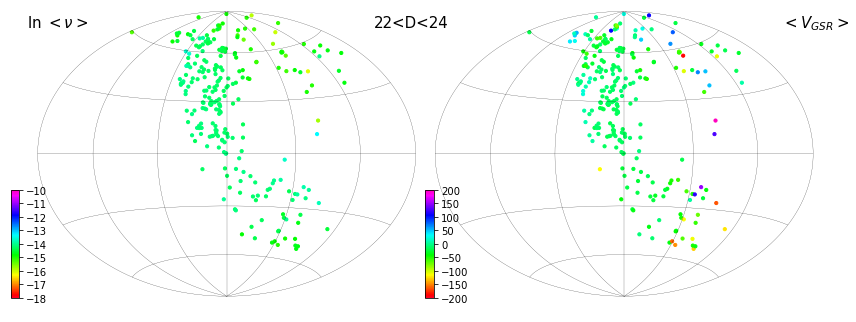

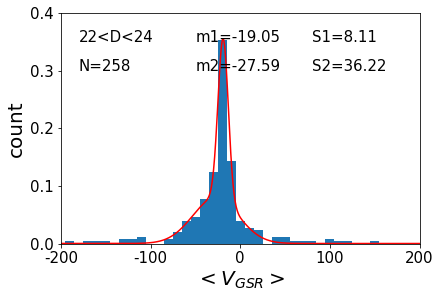

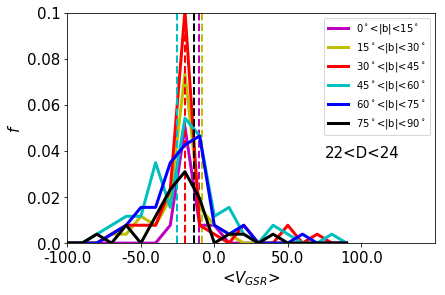

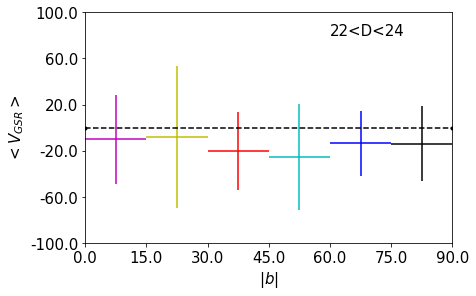

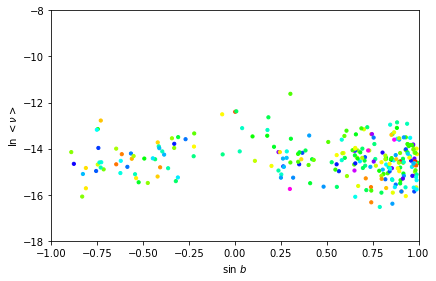

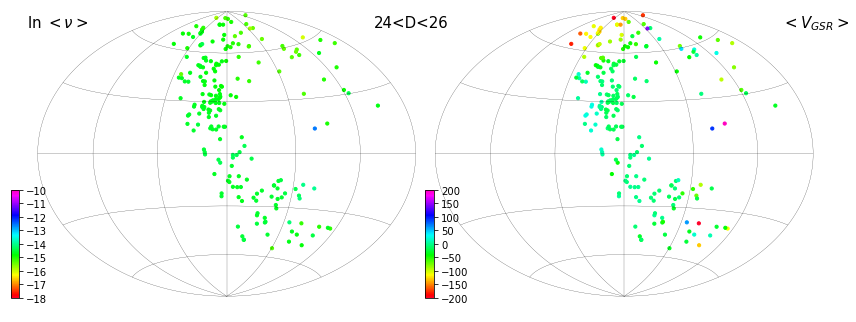

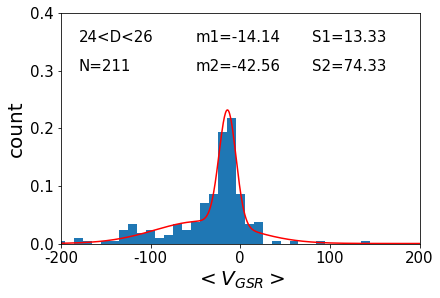

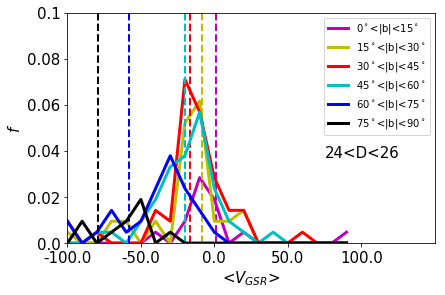

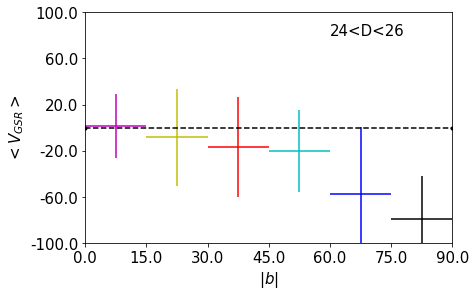

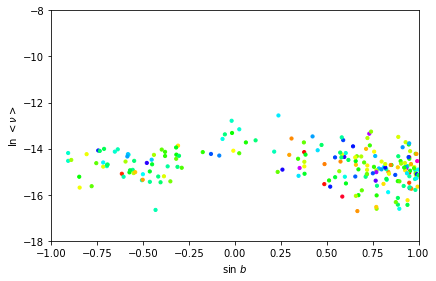

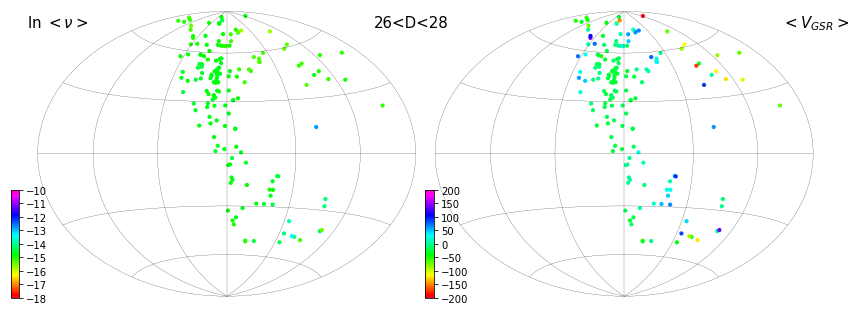

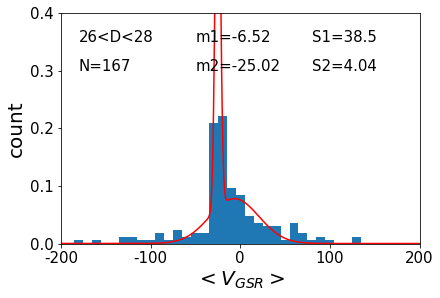

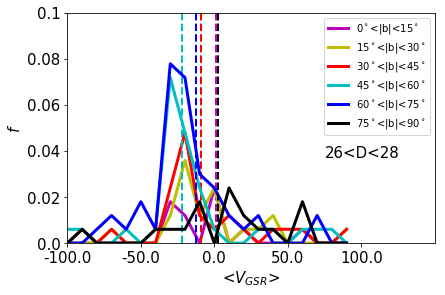

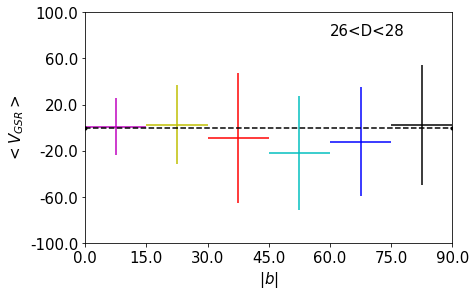

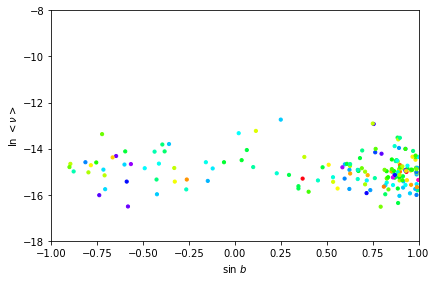

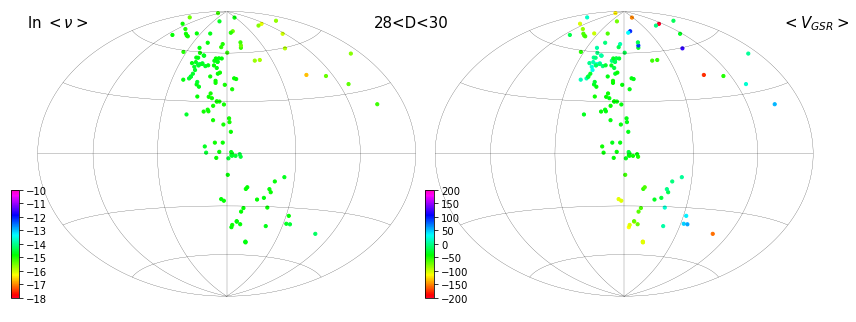

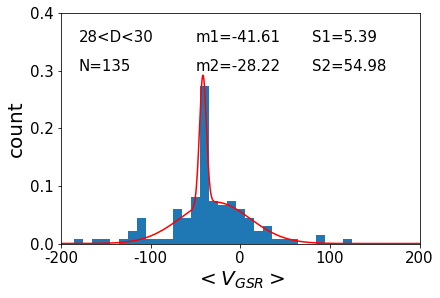

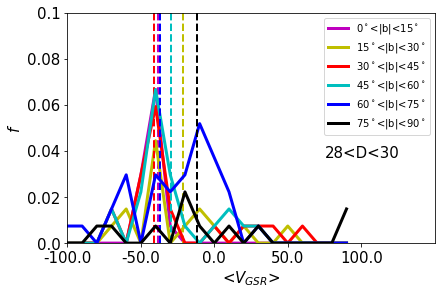

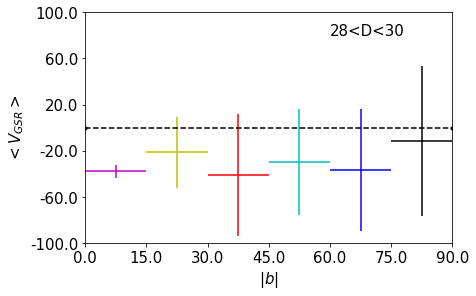

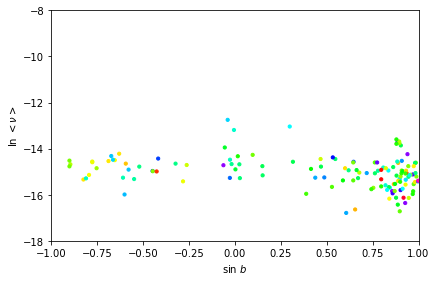

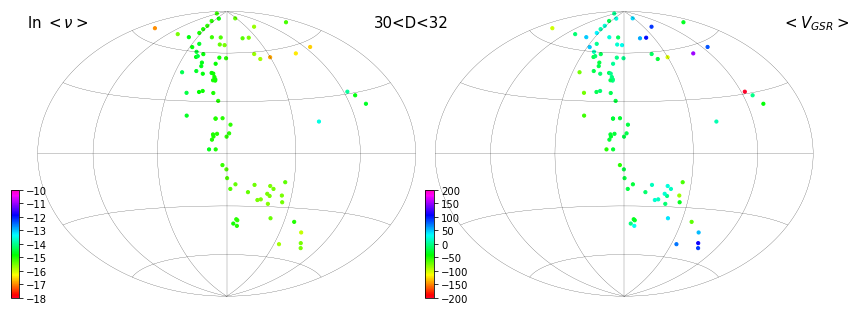

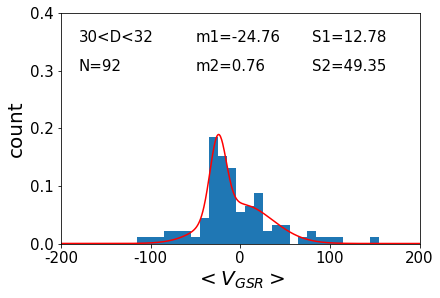

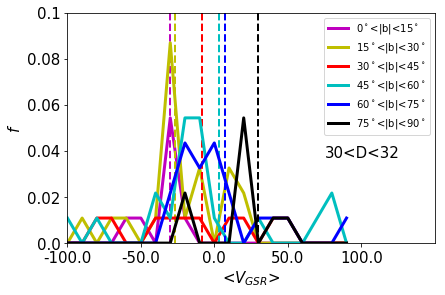

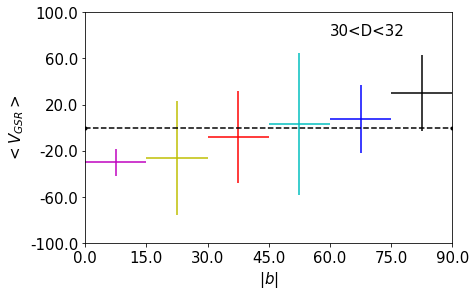

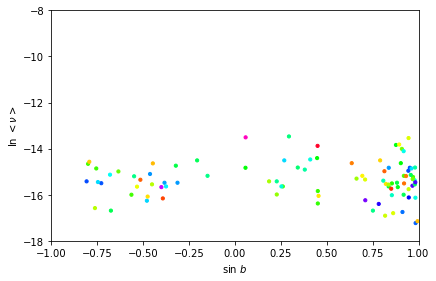

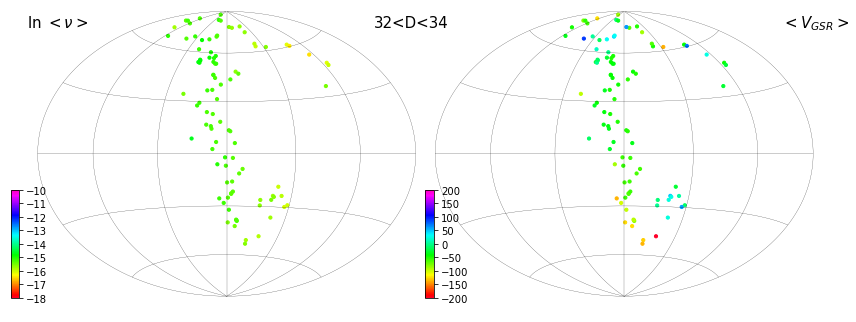

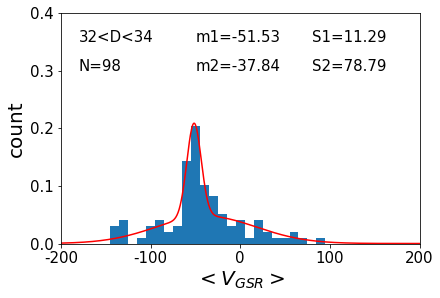

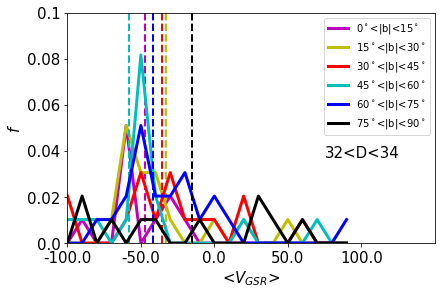

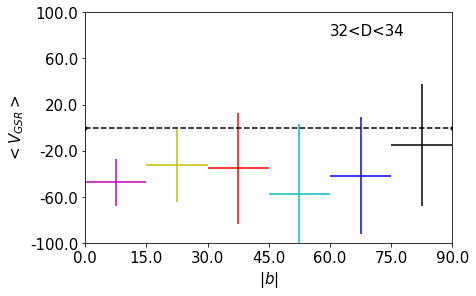

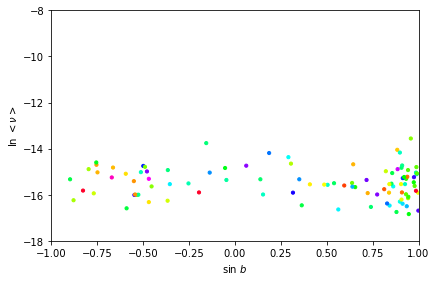

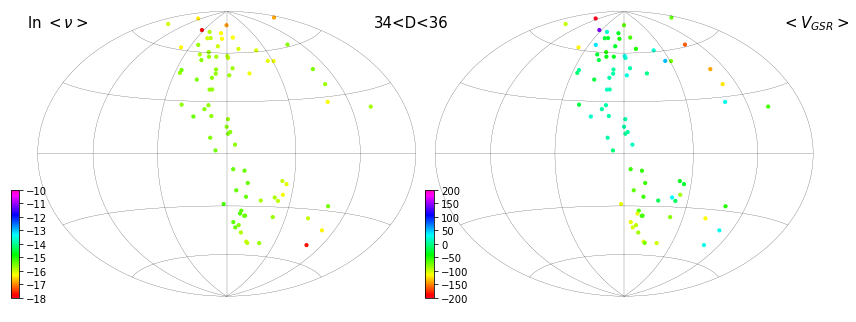

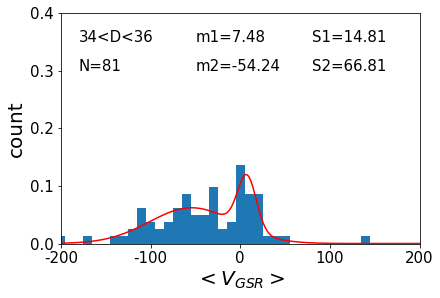

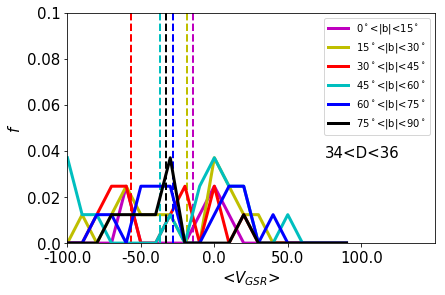

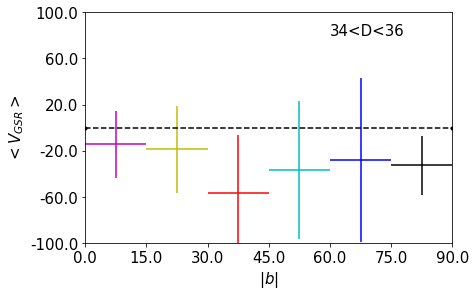

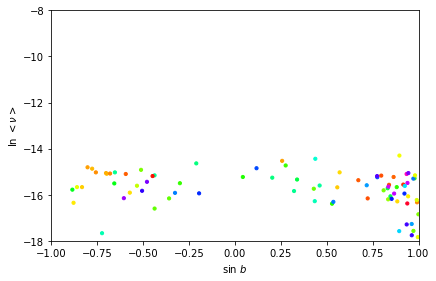

In [10]:
## lw=0.2
for i in range(0,13):
    dmin = 10+2*i
    dmax = dmin+2
    indd = (DD>dmin) & (DD<dmax)
    Xs0 = Xs[indd]
    Ys0 = Ys[indd]
    Zs0 = Zs[indd]
    nsd = len(DD[indd])
    Vgsr0 = Vgsr[indd]
    lnnu0 = lnnu[indd]
    b0=b[indd]
    l0=l[indd]
    M_vg0 = np.zeros(nsd)
    M_nu0 = np.zeros(nsd)
#     Disp_vg0 = np.zeros(nsd)
#     Disp_nu0 = np.zeros(nsd)
    for j in range(0,nsd):
        cosx0 = ((X_sun-Xs0)*(X_sun-Xs0[j])+Ys0*Ys0[j]+ \
        Zs0*Zs0[j])/np.sqrt((X_sun-Xs0[j])**2+Ys0[j]**2+Zs0[j]**2)/\
        np.sqrt((X_sun-Xs0)**2+Ys0[j]**2+Zs0[j]**2)
        indc = cosx0>cosAr
        if len(Vgsr0[indc])>0:
            M_vg0[j] = np.mean(Vgsr0[indc])
            M_nu0[j] = np.log(np.mean(math.e**(lnnu0[indc])))
#             Disp_vg0[j] = np.std(Vgsr0[indc])
#             Disp_nu0[j] = np.std(math.e**(lnnu0[indc]))

    
#     print(len(DD[indd]),dmin,dmax)
#     plt.close("all")
    fig1 = plt.figure(figsize=(12,5))
    ax1 = fig1.add_axes([0.05,0.1,0.44,0.8])
    ax2 = fig1.add_axes([0.51,0.1,0.44,0.8])
    ax1.plot(Xab0,Yab0,'k-',linewidth=lw)
    ax1.plot(Xab30,Yab30,'k-',linewidth=lw)
    ax1.plot(Xab60,Yab60,'k-',linewidth=lw)
    ax1.plot(Xab130,Yab130,'k-',linewidth=lw)
    ax1.plot(Xab160,Yab160,'k-',linewidth=lw)
    ax1.plot(Xal0,Yal0,'k-',linewidth=lw)
    ax1.plot(Xal60,Yal60,'k-',linewidth=lw)
    ax1.plot(Xal120,Yal120,'k-',linewidth=lw)
    ax1.plot(Xal180,Yal180,'k-',linewidth=lw)
    ax1.plot(Xal060,Yal060,'k-',linewidth=lw)
    ax1.plot(Xal0120,Yal0120,'k-',linewidth=lw)
    ax1.plot(Xal0180,Yal0180,'k-',linewidth=lw)
    cax1 = ax1.scatter(Xa[indd],Ya[indd],s=10,c=M_nu0,vmin=-18,vmax=-10,cmap='gist_rainbow')
    ax1.axis([-181,181,-91,91])
    ax1.axis("off")
    
    
    ax2.plot(Xab0,Yab0,'k-',linewidth=lw)
    ax2.plot(Xab30,Yab30,'k-',linewidth=lw)
    ax2.plot(Xab60,Yab60,'k-',linewidth=lw)
    ax2.plot(Xab130,Yab130,'k-',linewidth=lw)
    ax2.plot(Xab160,Yab160,'k-',linewidth=lw)
    ax2.plot(Xal0,Yal0,'k-',linewidth=lw)
    ax2.plot(Xal60,Yal60,'k-',linewidth=lw)
    ax2.plot(Xal120,Yal120,'k-',linewidth=lw)
    ax2.plot(Xal180,Yal180,'k-',linewidth=lw)
    ax2.plot(Xal060,Yal060,'k-',linewidth=lw)
    ax2.plot(Xal0120,Yal0120,'k-',linewidth=lw)
    ax2.plot(Xal0180,Yal0180,'k-',linewidth=lw)
    cax2 = ax2.scatter(Xa[indd],Ya[indd],s=10,c=M_vg0,vmin=-200,vmax=200,cmap="gist_rainbow")
    ax2.axis([-181,181,-91,91])
    ax2.axis("off")
    
    ax1.text(140,80,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    ax1.text(-190,80,"ln $<\\nu>$".format(**locals()),fontsize=15)
    ax2.text(150,80,"$<V_{GSR}>$",fontsize=15)
    
    ax3 = fig1.add_axes([0.02,0.1,0.01,0.3])
    ax4 = fig1.add_axes([0.5,0.1,0.01,0.3])
    plt.colorbar(cax1,ax3)
    plt.colorbar(cax2,ax4)
    plt.savefig(ppath+"Smooth_lnnu_Vgsr_vx_D_{dmin}_{dmax}.eps".format(**locals()))
#     plt.close(fig1)
    
    figh = plt.figure(figsize=(6,4))
    ax = figh.add_axes([0.14,0.17,0.83,0.8])
    hy,hx = np.histogram(M_vg0,bins=np.linspace(-200,200,41))
    popt,pcov = SO.curve_fit(Gaussian2,hx[:len(hx)-1],hy*1.0/nsd,bounds=([0,0,-300,-300,0,0],\
        [1,1,300,300,300,300]))
    m1 = round(popt[2],2)
    m2 = round(popt[3],2)
    s1 = round(popt[4],2)
    s2 = round(popt[5],2)
    xxxx = np.linspace(-300,300,1000) 
    plt.bar(hx[:len(hx)-1],hy*1.0/nsd,width=10)
    plt.plot(xxxx,Gaussian2(xxxx,*popt),'r-')
    plt.xlabel("$<V_{GSR}>$",fontsize=20)
    plt.ylabel("count",fontsize=20)
    plt.axis([-200,200,0,0.4])
    plt.yticks(np.linspace(0,0.4,5),['0.0','0.1','0.2','0.3','0.4'],fontsize=15)
    plt.xticks(np.linspace(-200,200,5),['-200','-100','0','100','200'],fontsize=15)
    plt.text(-180,0.35,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    plt.text(-180,0.3,"N={nsd}".format(**locals()),fontsize=15)
    plt.text(-50,0.35,"m1={m1}".format(**locals()),fontsize=15)
    plt.text(-50,0.3,"m2={m2}".format(**locals()),fontsize=15)
    plt.text(80,0.35,"S1={s1}".format(**locals()),fontsize=15)
    plt.text(80,0.3,"S2={s2}".format(**locals()),fontsize=15)
    plt.savefig(ppath+"hist_M_vg_D_{dmin}_{dmax}.eps".format(**locals()))
#     plt.close(figh)
#     print(np.min(M_vg0),np.max(M_vg0))




#     check the mean velocity along the latitude
    figb = plt.figure(figsize=(6,4))
    figbb = plt.figure(figsize=(6,4))
    ax2 = figbb.add_axes([0.12,0.17,0.85,0.8])
    ax1 = figb.add_axes([0.12,0.17,0.85,0.8])
    for k in range(0,len(bbins)-1):
        inddb = (np.abs(b0)>=bbins[k]) & (np.abs(b0)<bbins[k+1])
        if len(b0[inddb])>0:
            hyb,hxb = np.histogram(M_vg0[inddb],bins=np.linspace(-100,100,21))
            bmin = int(bbins[k])
            bmax = int(bbins[k+1])
            ax1.plot(hxb[:len(hxb)-1],hyb*1.0/len(M_vg[indd]),sym[k],\
                     label='{bmin}$^\\circ$<|b|<{bmax}$^\\circ$'.format(**locals()),linewidth=3)
            ax1.plot([np.mean(M_vg0[inddb]),np.mean(M_vg0[inddb])],[0,1],lsym[k],linewidth=2)
            ax2.errorbar([bbins[k]+7.5],[np.mean(M_vg0[inddb])],xerr = 7.5,yerr=np.std(M_vg0[inddb]),fmt=sym[k])
    ax1.set_xlim((-100,150))
    ax1.set_ylim((0,0.1))
    ax1.set_xticks(np.linspace(-100,100,5))
    ax1.set_xticklabels(np.linspace(-100,100,5),fontsize=15)
    ax1.set_xlabel('<$V_{GSR}$>',fontsize=15)
    ax1.set_yticks(np.linspace(0,0.1,6))
    ax1.set_yticklabels(np.linspace(0,0.1,6),fontsize=15)
    ax1.set_ylabel('$f$',fontsize=15)
    ax1.legend(loc=1,fontsize=10)
    ax1.text(75,0.037,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    figb.savefig(ppath+"Mean_Vgsr_D_B_{dmin}_{dmax}.eps".format(**locals()))
#     plt.close(figb)
    
    
    ax2.plot([0,90],[0,0],'k.--',linewidth=1.5)
    ax2.set_xlim((0,90))
    ax2.set_ylim((-100,100))
    ax2.set_xticks(np.linspace(0,90,7))
    ax2.set_xticklabels(np.linspace(0,90,7),fontsize=15)
    ax2.set_xlabel('|$b$|',fontsize=15)
    ax2.set_yticks(np.linspace(-100,100,6))
    ax2.set_yticklabels(np.linspace(-100,100,6),fontsize=15)
    ax2.set_ylabel('$<V_{GSR}>$',fontsize=15)
    ax2.legend(loc=1,fontsize=10)
    ax2.text(60,80,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    figbb.savefig(ppath+"Mean_Vgsr_B_{dmin}_{dmax}.eps".format(**locals()))
#     plt.close(figbb)
    
    figdv = plt.figure(figsize=(6,4))
    ax0 = figdv.add_axes([0.12,0.17,0.85,0.8])
    ax0.scatter(np.sin(b0*math.pi/180),lnnu0,c=Vgsr0,s=10,cmap='gist_rainbow')
    ax0.set_ylim((-18,-8))
    ax0.set_xlim((-1,1))
    ax0.set_xlabel('sin $b$')
    ax0.set_ylabel('ln $<\\nu>$')
    figdv.savefig(ppath+"B_nu_Vg_{dmin}_{dmax}.eps".format(**locals()))


# plot dispersion of density and Vgsr

In [11]:
# # plot dispersion
# lw=0.2
# for i in range(0,13):
#     dmin = 10+2*i
#     dmax = dmin+2
#     indd = (DD>dmin) & (DD<dmax)
    
#     Xs0 = Xs[indd]
#     Ys0 = Ys[indd]
#     Zs0 = Zs[indd]
#     nsd = len(DD[indd])
#     Vgsr0 = Vgsr[indd]
#     lnnu0 = lnnu[indd]
#     Disp_vg0 = np.zeros(nsd)
#     Disp_nu0 = np.zeros(nsd)
#     for j in range(0,nsd):
#         cosx0 = ((X_sun-Xs0)*(X_sun-Xs0[j])+Ys0*Ys0[j]+ \
#         Zs0*Zs0[j])/np.sqrt((X_sun-Xs0[j])**2+Ys0[j]**2+Zs0[j]**2)/\
#         np.sqrt((X_sun-Xs0)**2+Ys0[j]**2+Zs0[j]**2)
#         indc = cosx0>cosAr
#         if len(Vgsr0[indc])>0:
#             Disp_vg0[j] = np.std(Vgsr0[indc])
#             Disp_nu0[j] = np.std(math.e**(lnnu0[indc]))

#     fig1 = plt.figure(figsize=(12,5))
#     ax1 = fig1.add_axes([0.05,0.1,0.44,0.8])
#     ax2 = fig1.add_axes([0.51,0.1,0.44,0.8])
#     ax1.plot(Xab0,Yab0,'k-',linewidth=lw)
#     ax1.plot(Xab30,Yab30,'k-',linewidth=lw)
#     ax1.plot(Xab60,Yab60,'k-',linewidth=lw)
#     ax1.plot(Xab130,Yab130,'k-',linewidth=lw)
#     ax1.plot(Xab160,Yab160,'k-',linewidth=lw)
#     ax1.plot(Xal0,Yal0,'k-',linewidth=lw)
#     ax1.plot(Xal60,Yal60,'k-',linewidth=lw)
#     ax1.plot(Xal120,Yal120,'k-',linewidth=lw)
#     ax1.plot(Xal180,Yal180,'k-',linewidth=lw)
#     ax1.plot(Xal060,Yal060,'k-',linewidth=lw)
#     ax1.plot(Xal0120,Yal0120,'k-',linewidth=lw)
#     ax1.plot(Xal0180,Yal0180,'k-',linewidth=lw)
#     cax1 = ax1.scatter(Xa[indd],Ya[indd],s=10,c=Disp_nu0,vmin=0,vmax=1e-5,cmap='gist_rainbow')
#     ax1.axis([-181,181,-91,91])
#     ax1.axis("off")
    
    
#     ax2.plot(Xab0,Yab0,'k-',linewidth=lw)
#     ax2.plot(Xab30,Yab30,'k-',linewidth=lw)
#     ax2.plot(Xab60,Yab60,'k-',linewidth=lw)
#     ax2.plot(Xab130,Yab130,'k-',linewidth=lw)
#     ax2.plot(Xab160,Yab160,'k-',linewidth=lw)
#     ax2.plot(Xal0,Yal0,'k-',linewidth=lw)
#     ax2.plot(Xal60,Yal60,'k-',linewidth=lw)
#     ax2.plot(Xal120,Yal120,'k-',linewidth=lw)
#     ax2.plot(Xal180,Yal180,'k-',linewidth=lw)
#     ax2.plot(Xal060,Yal060,'k-',linewidth=lw)
#     ax2.plot(Xal0120,Yal0120,'k-',linewidth=lw)
#     ax2.plot(Xal0180,Yal0180,'k-',linewidth=lw)
#     cax2 = ax2.scatter(Xa[indd],Ya[indd],s=10,c=Disp_vg0,vmin=80,vmax=130,cmap="gist_rainbow")
#     ax2.axis([-181,181,-91,91])
#     ax2.axis("off")
    
#     ax1.text(140,80,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
#     ax1.text(-190,80,"$\\sigma_{\\nu}$",fontsize=15)
#     ax2.text(150,80,"$\\sigma_{V_{GSR}}$",fontsize=15)
    
#     ax3 = fig1.add_axes([0.02,0.1,0.01,0.3])
#     ax4 = fig1.add_axes([0.5,0.1,0.01,0.3])
#     plt.colorbar(cax1,ax3)
#     plt.colorbar(cax2,ax4)
#     plt.savefig(ppath+"Smooth_disp_lnnu_Vgsr_vx_D_{dmin}_{dmax}.eps".format(**locals()))
# #     plt.close(fig1)
    
#     figh = plt.figure(figsize=(6,4))
#     ax = figh.add_axes([0.14,0.17,0.83,0.8])
#     hy,hx = np.histogram(Disp_vg0,bins=np.linspace(50,150,21))
#     plt.bar(hx[:len(hx)-1],hy*1.0/nsd,width=5)
#     plt.xlabel("$\\sigma_{V_{GSR}}$",fontsize=20)
#     plt.ylabel("count",fontsize=20)
#     plt.axis([50,150,0,0.5])
#     plt.yticks(np.linspace(0,0.5,6),['0.0','0.1','0.2','0.3','0.4','0.5'],fontsize=15)
#     plt.xticks(np.linspace(50,150,6),['50','70','90','110','130','150'],fontsize=15)
#     plt.text(60,0.4,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
#     plt.text(60,0.3,"N={nsd}".format(**locals()),fontsize=15)
#     plt.savefig(ppath+"hist_disp_vg_D_{dmin}_{dmax}.eps".format(**locals()))
# #     plt.close(figh)
#     del indd

# plot radial velocity

In [12]:
# ## lw=0.2
# for i in range(0,13):
#     dmin = 10+2*i
#     dmax = dmin+2
#     indd = (DD>dmin) & (DD<dmax)
#     Xs0 = Xs[indd]
#     Ys0 = Ys[indd]
#     Zs0 = Zs[indd]
#     nsd = len(DD[indd])
#     rv0 = rv[indd]
#     M_rv0 = np.zeros(nsd)
#     M_nu0 = np.zeros(nsd)
#     lnnu0 = lnnu[indd]
#     for j in range(0,nsd):
#         cosx0 = ((Xs0)*(Xs0[j])+Ys0*Ys0[j]+ \
#         Zs0*Zs0[j])/np.sqrt((Xs0[j])**2+Ys0[j]**2+Zs0[j]**2)/\
#         np.sqrt((Xs0)**2+Ys0[j]**2+Zs0[j]**2)
#         indc = cosx0>cosAr
#         if len(rv0[indc])>0:
#             M_rv0[j] = np.mean(rv0[indc])
#             M_nu0[j] = np.log(np.mean(math.e**(lnnu0[indc])))
 
#     fig1 = plt.figure(figsize=(12,5))
#     ax1 = fig1.add_axes([0.05,0.1,0.44,0.8])
#     ax2 = fig1.add_axes([0.51,0.1,0.44,0.8])
#     ax1.plot(Xab0,Yab0,'k-',linewidth=lw)
#     ax1.plot(Xab30,Yab30,'k-',linewidth=lw)
#     ax1.plot(Xab60,Yab60,'k-',linewidth=lw)
#     ax1.plot(Xab130,Yab130,'k-',linewidth=lw)
#     ax1.plot(Xab160,Yab160,'k-',linewidth=lw)
#     ax1.plot(Xal0,Yal0,'k-',linewidth=lw)
#     ax1.plot(Xal60,Yal60,'k-',linewidth=lw)
#     ax1.plot(Xal120,Yal120,'k-',linewidth=lw)
#     ax1.plot(Xal180,Yal180,'k-',linewidth=lw)
#     ax1.plot(Xal060,Yal060,'k-',linewidth=lw)
#     ax1.plot(Xal0120,Yal0120,'k-',linewidth=lw)
#     ax1.plot(Xal0180,Yal0180,'k-',linewidth=lw)
#     cax1 = ax1.scatter(Xas[indd],Yas[indd],s=10,c=M_nu0,vmin=-18,vmax=-10,cmap='gist_rainbow')
#     ax1.axis([-181,181,-91,91])
#     ax1.axis("off")
    
    
#     ax2.plot(Xab0,Yab0,'k-',linewidth=lw)
#     ax2.plot(Xab30,Yab30,'k-',linewidth=lw)
#     ax2.plot(Xab60,Yab60,'k-',linewidth=lw)
#     ax2.plot(Xab130,Yab130,'k-',linewidth=lw)
#     ax2.plot(Xab160,Yab160,'k-',linewidth=lw)
#     ax2.plot(Xal0,Yal0,'k-',linewidth=lw)
#     ax2.plot(Xal60,Yal60,'k-',linewidth=lw)
#     ax2.plot(Xal120,Yal120,'k-',linewidth=lw)
#     ax2.plot(Xal180,Yal180,'k-',linewidth=lw)
#     ax2.plot(Xal060,Yal060,'k-',linewidth=lw)
#     ax2.plot(Xal0120,Yal0120,'k-',linewidth=lw)
#     ax2.plot(Xal0180,Yal0180,'k-',linewidth=lw)
#     cax2 = ax2.scatter(Xas[indd],Yas[indd],s=10,c=M_rv0,vmin=-200,vmax=200,cmap="gist_rainbow")
#     ax2.axis([-181,181,-91,91])
#     ax2.axis("off")
    
#     ax1.text(140,80,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
#     ax1.text(-190,80,"ln $<\\nu>$".format(**locals()),fontsize=15)
#     ax2.text(150,80,"$<RV>$",fontsize=15)
    
#     ax3 = fig1.add_axes([0.02,0.1,0.01,0.3])
#     ax4 = fig1.add_axes([0.5,0.1,0.01,0.3])
#     plt.colorbar(cax1,ax3)
#     plt.colorbar(cax2,ax4)
#     plt.savefig(ppath+"Smooth_lnnu_rv_vx_D_{dmin}_{dmax}.eps".format(**locals()))
# #     plt.close(fig1)
    
# #     figh = plt.figure(figsize=(6,4))
# #     ax = figh.add_axes([0.14,0.17,0.83,0.8])
# #     hy,hx = np.histogram(M_vg0,bins=np.linspace(-200,200,41))
# #     plt.bar(hx[:len(hx)-1],hy*1.0/nsd,width=10)
# #     plt.xlabel("$<V_{GSR}>$",fontsize=20)
# #     plt.ylabel("count",fontsize=20)
# #     plt.axis([-200,200,0,0.4])
# #     plt.yticks(np.linspace(0,0.4,5),['0.0','0.1','0.2','0.3','0.4'],fontsize=15)
# #     plt.xticks(np.linspace(-200,200,5),['-200','-100','0','100','200'],fontsize=15)
# #     plt.text(60,0.3,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
# #     plt.text(-140,0.3,"N={nsd}".format(**locals()),fontsize=15)
# #     plt.savefig(ppath+"hist_M_vg_D_{dmin}_{dmax}.eps".format(**locals()))
# # #     plt.close(figh)
# # #     print(np.min(M_vg0),np.max(M_vg0))

In [13]:
# figh = plt.figure(figsize=(6,4))
# hy,hx = np.histogram(M_vg,bins=np.linspace(-50,50,51))
# plt.bar(hx[:len(hx)-1],hy,width=2)
# plt.xlabel("$V_{GSR}$",fontsize=20)
# plt.ylabel("count",fontsize=20)
# plt.savefig(ppath+"hist_M_vg.eps")

In [14]:
# # check the distribution of the density
# hy,hx = np.histogram(Disp_vg,bins=np.linspace(80,130,51))
# plt.plot(hx[:len(hx)-1],hy)

# print(np.min(Disp_vg),np.max(Disp_vg))

In [15]:
# print(np.log(math.e))

In [16]:
# print(np.min(M_nu),np.max(M_nu))

In [17]:

# print(len(DD[(DD>25) & (DD<26)]))